<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/NCD_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fairseq sacrebleu sentencepiece
from google.colab import drive
drive.mount('/content/drive')
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

     |████████████████████████████████| 307kB 14.5MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 1.0MB 49.6MB/s 
     |████████████████████████████████| 17.1MB 207kB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035390 sha256=e52498a192dc227a519f6f5e2d707eb9f68199fa67c6a972fbb194463b5c12d4
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your

Generic Methods and Classes

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from statistics import mean, median 


class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

    for i in range(len(translations)):
        if i < split_index:
            temporary_reference_exclusion.write(translations[i].reference)
            temporary_output_exclusion.write(translations[i].translation)
        else:
            temporary_reference_inclusion.write(translations[i].reference)
            temporary_output_inclusion.write(translations[i].translation)

    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)

def produce_statistics():
    bleu_res = open("analysis/testSet_BLEU.txt", "r")
    NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "w")
    NMT_output = open("analysis/translated_sentences.txt", "w")
    Sentence_stats = open("analysis/logprob_statistics.txt", "w")

    for line in bleu_res:
        if line.startswith("H-"):
            NMT_output.write(line.split("	")[2])
        elif line.startswith("T-"):
            NMT_ground_truth.write(line.split("	")[1])
        elif line.startswith("P-"):
            scores = [float(i) for i in line.split("\t")[1].split(" ")]
            Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+"\n")

    NMT_ground_truth.close()
    NMT_output.close()
    Sentence_stats.close()

Generate Predictions and SacreBlue for baseline

In [0]:
!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang ne --target-lang en \
    --path Ensembles/April_04.pt \
    --beam 5 --lenpen 1.2 \
    --gen-subset test \
    --remove-bpe=sentencepiece \
    --sacrebleu > analysis/testSet_BLEU.txt

produce_statistics()

  0% 0/14 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
!fairseq-score --sys analysis/translated_sentences.txt --ref analysis/ground_truth_sentences.txt --sentence-bleu > analysis/scores.txt

Create 2 arrays - one with baseline translations with logprob stats and another with sentence level bleu (oracle)

In [0]:
NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_stats = open("analysis/logprob_statistics.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")
next(Sentence_bleu)

files = [NMT_ground_truth, NMT_output, Sentence_stats, Sentence_bleu]
baseline_logprob_translations = []
baseline_oracle_translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    baseline_logprob_translations.append(Translation(reference, translation, stats[0]))
    baseline_oracle_translations.append(Translation(reference, translation, sentence_bleu))

Generate Predictions and SacreBleu for ensemble


In [0]:
import glob
path = 'Ensembles/*'
ensemble_models = ""
for file in glob.glob(path):
  ensemble_models += file + ":"
ensemble_models = ensemble_models[:-1]

!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang ne --target-lang en \
    --path $ensemble_models \
    --beam 5 --lenpen 1.2 \
    --gen-subset test \
    --remove-bpe=sentencepiece \
    --sacrebleu > analysis/testSet_BLEU.txt

produce_statistics()

  0% 0/14 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
Traceback (most recent call last):
  File "/usr/local/bin/fairseq-generate", line 8, in <module>
    sys.exit(cli_main())
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/generate.py", line 199, in cli_main
    main(args)
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/generate.py", line 104, in main
    hypos = task.inference_step(generator, models, sample, prefix_tokens)
  File "/usr/local/lib/python3.6/dist-packages/fairseq/tasks/fairseq_task.py", line 265, in inference_step
    return generator.generate(models, sample, prefix_tokens=prefix_tokens)
  File "/usr/local/lib/python3.6/dist-packages/torch/autograd/grad_mode.py", line 15, in decorate_context
    return func(*args, **kwargs)
  File "/u

Create array with ensemble translations with average logprob of tokens

In [0]:
NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_stats = open("analysis/logprob_statistics.txt", "r")

files = [NMT_ground_truth, NMT_output, Sentence_stats]
ensemble_translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, stats = lines
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    ensemble_translations.append(Translation(reference, translation, stats[0]))

ensemble_translations.sort(key=lambda x: x.score, reverse=False)

Create array with ncd_no_ensembling translations with re-rank score

In [0]:
ncd_no_ensembling_hypos = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_20_subset_test_fw/matched_hypos", "r")
ncd_no_ensembling_gt = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_20_subset_test_fw/matched_targets", "r")
ncd_no_ensembling_scores = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_20_subset_test_fw/hypos_scores", "r")

ncd_no_ensembling_translations = []

files = [ncd_no_ensembling_hypos, ncd_no_ensembling_gt, ncd_no_ensembling_scores]
for lines in zip_longest(*files, fillvalue=''):
    translation, reference, score = lines
    ncd_no_ensembling_translations.append(Translation(reference, translation, float(score)))

ncd_no_ensembling_translations.sort(key=lambda x: x.score, reverse=False)

Create array with ncd_ensembling translations with re-rank score


In [0]:
ncd_ensembling_hypos = open("noisychannel/rerank_data/ncd_with_ensembling/nbest_20_subset_test_fw/matched_hypos", "r")
ncd_ensembling_gt = open("noisychannel/rerank_data/ncd_with_ensembling/nbest_20_subset_test_fw/matched_targets", "r")
ncd_ensembling_scores = open("noisychannel/rerank_data/ncd_with_ensembling/nbest_20_subset_test_fw/hypos_scores", "r")

ncd_ensembling_translations = []

files = [ncd_ensembling_hypos, ncd_ensembling_gt, ncd_ensembling_scores]
for lines in zip_longest(*files, fillvalue=''):
    translation, reference, score = lines
    ncd_ensembling_translations.append(Translation(reference, translation, float(score)))

ncd_ensembling_translations.sort(key=lambda x: x.score, reverse=False)

In [0]:
print(len(baseline_logprob_translations))
print(len(baseline_oracle_translations))
print(len(ensemble_translations))
print(len(ncd_no_ensembling_translations))
print(len(ncd_ensembling_translations))

2835
2835
0
2835
2835


Get the following 5 plots on the same graph - 

Average logprob thresholding of baseline model

Same but for ensemble

Same but for baseline reranked with NCD

Same but for NCD ensemble

Oracle BLEU of the baseline

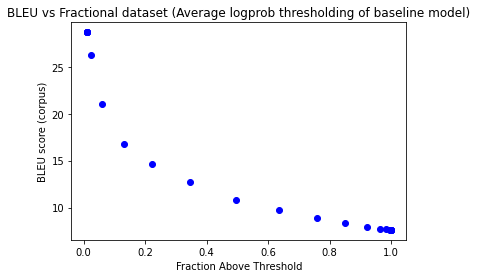

AUC for incuded fraction: 12.035084656084656


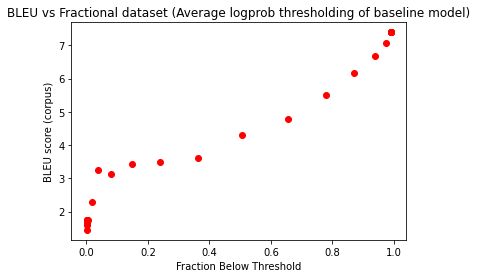

AUC for excluded fraction: 4.41221340388007


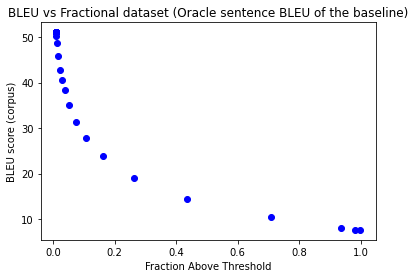

AUC for incuded fraction: 15.946908289241623


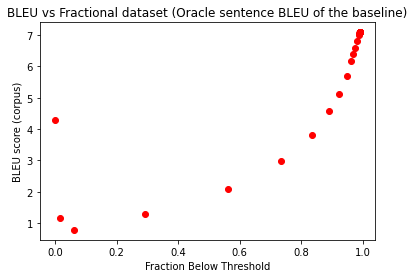

AUC for excluded fraction: 2.3508324514991186
Traceback (most recent call last):
  File "/usr/local/bin/fairseq-score", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 84, in main
    score(f)
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 59, in score
    print(sacrebleu.corpus_bleu(fdsys, [fdref]))
  File "/usr/local/lib/python3.6/dist-packages/sacrebleu/sacrebleu.py", line 455, in __str__
    return self.format()
  File "/usr/local/lib/python3.6/dist-packages/sacrebleu/sacrebleu.py", line 483, in format
    ratio=self.sys_len / self.ref_len,
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/usr/local/bin/fairseq-score", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 84, in main
    score(f)
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 59, in score
    print(sacr

IndexError: ignored

In [0]:
import numpy as np
import random

index_to_label = {0:"Average logprob thresholding of baseline model", 1:"Oracle sentence BLEU of the baseline", 2:"Average logprob thresholding of ensemble", 3:"Re-rank score thresholding of NCD", 4:"Re-rank score thresholding of NCD with ensemble"}

thresholding_data = [baseline_logprob_translations, baseline_oracle_translations, ensemble_translations, ncd_no_ensembling_translations, ncd_ensembling_translations]
all_inclusion_scores = []
all_fractions_included = []

for index in range(len(thresholding_data)):
    thresholding_data[index].sort(key=lambda x: x.score, reverse=False)
    translations = thresholding_data[index]

    # print("Worst reference: " +translations[0].reference+" Worst translation: "+translations[0].translation)
    thresholds = []


    ##Trying to get 25 good thresholds for each case
    if index == 0:
        thresholds = np.linspace(-1.5, 0, 25).tolist()
        # thresholds = [i for i in arange(-1.5, 0, 0.07)]
    elif index == 1:
        thresholds = np.linspace(0, 70, 25).tolist()
        # thresholds = [i for i in arange(0, 70, 3)]
    elif index == 2:
        thresholds = np.linspace(-1.5, 0, 25).tolist()
        # thresholds = [i for i in arange(-1.5, 0, 0.07)]
    elif index == 3:
        thresholds = np.linspace(-275, -40, 25).tolist()
        # thresholds = [i for i in arange(-275, -40, 25)]
    elif index == 4:
        thresholds = np.linspace(-370, -50, 25).tolist()
        # thresholds = [i for i in arange(-370, -50, 25)]

    inclusion_scores = []
    exclusion_scores = []
    fraction_included = []
    fraction_excluded = []

    for threshold in thresholds:
        split_index = 1 ## We always start at 1 so that the exclusion set is never empty. 
        while split_index < 0.99*len(translations) and translations[split_index].score < threshold:  ##0.95*len(translations) - to make sure the inclusion set always has a good number of examples
            split_index += 1
        exclusion, inclusion = compute_excluded_included_score(translations, split_index)
        inclusion_scores.append(inclusion)
        exclusion_scores.append(exclusion)
        fraction_included.append((len(translations) - split_index)/len(translations))
        fraction_excluded.append(split_index/len(translations))
    
    all_inclusion_scores.append(inclusion_scores)
    all_fractions_included.append(fraction_included)

    #########################   PLOTING   ################################
    plt.scatter(fraction_included, inclusion_scores, color= "blue")
    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel('BLEU score (corpus)') 
    plt.title('BLEU vs Fractional dataset ('+index_to_label[index]+')') 
    plt.show() 

    print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))

    plt.scatter(fraction_excluded, exclusion_scores, color= "red")
    plt.xlabel('Fraction Below Threshold') 
    plt.ylabel('BLEU score (corpus)') 
    plt.title('BLEU vs Fractional dataset ('+index_to_label[index]+')') 
    plt.show()  

    print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))
    ####################################################################

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('Comparing NMTs') 
for i in range(len(all_inclusion_scores)):
    r = random.random()
    b = random.random()
    g = random.random()
    c = (r, g, b)
    plt.plot(all_fractions_included[i], all_inclusion_scores[i], label = index_to_label[i], color=c)

plt.legend(loc="upper right")
plt.show()

In [0]:
#Read LM_Scores file into an ordered list of floats
lm_scores = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_5_subset_test_fw_name_ne-en_shard_0_of_1/lm_scores", "r")
lm_scores_list = []
for line in lm_scores:
  lm_scores_list.append(float(line[:-1]))
print("min val: ", min(lm_scores_list))
print("max val: ", max(lm_scores_list))
lower_bound = min(lm_scores_list)
upper_bound = max(lm_scores_list)

from itertools import zip_longest

class Translation:
    def __init__ (self, ref, out):
        self.reference = ref
        self.translation = out

def get_sentence_pairs():
  NCD_ground_truth = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_5_subset_test_fw_name_ne-en_shard_0_of_1/matched_targets", "r")
  NCD_output = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_5_subset_test_fw_name_ne-en_shard_0_of_1/matched_hypos", "r")
  files = [NCD_ground_truth, NCD_output]
  translations = []
  for lines in zip_longest(*files, fillvalue=''):
    reference, translation = lines
    translations.append(Translation(reference, translation))
  return translations

def compute_excluded_included_score(translations, thresh):
  temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
  temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

  temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
  temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

  num_exc = 0
  for i, lm in enumerate(lm_scores_list):
    if lm < thresh:
      temporary_reference_exclusion.write(translations[i].reference)
      temporary_output_exclusion.write(translations[i].translation)
      num_exc += 1
    else:
      temporary_reference_inclusion.write(translations[i].reference)
      temporary_output_inclusion.write(translations[i].translation)
  temporary_reference_inclusion.close()
  temporary_output_inclusion.close()
  temporary_reference_exclusion.close()
  temporary_output_exclusion.close()

  !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
  !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

  temporary_inclusion_result = open("analysis/inclusion_result.txt")
  temporary_exclusion_result = open("analysis/exclusion_result.txt")
  inclusion_result_string = [line for line in temporary_inclusion_result]
  if len(inclusion_result_string) > 1:
    inclusion_result_string = float(inclusion_result_string[1].split(" ")[2])
  else:
    inclusion_result_string = float(0)
  exclusion_result_string = [line for line in temporary_exclusion_result]
  if len(exclusion_result_string) > 1:
    exclusion_result_string = float(exclusion_result_string[1].split(" ")[2])
  else:
    exclusion_result_string = float(0)
  return exclusion_result_string, inclusion_result_string, num_exc

min val:  -454.796458
max val:  -46.785695


25
BLEU SCORES AT LM THRESHOLD VALUE:  -453.796458
Excluded BLEU:  1.53
Included BLEU:  7.92 

BLEU SCORES AT LM THRESHOLD VALUE:  -437.55602747999995
Excluded BLEU:  0.78
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -421.31559695999994
Excluded BLEU:  0.64
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -405.0751664399999
Excluded BLEU:  1.0
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -388.8347359199999
Excluded BLEU:  0.88
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -372.5943053999999
Excluded BLEU:  0.88
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -356.35387487999986
Excluded BLEU:  1.05
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -340.11344435999985
Excluded BLEU:  4.14
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -323.8730138399998
Excluded BLEU:  3.96
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -307.6325833199998
Excluded BLEU:  4.9
Included BLEU:  7.95 

BLEU SCORES 

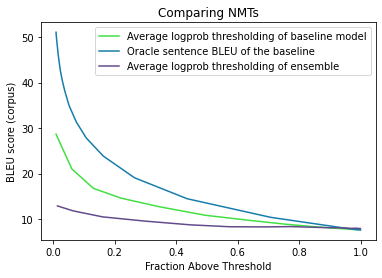

In [0]:
from numpy import arange
import matplotlib.pyplot as plt
from sklearn.metrics import auc

translations = get_sentence_pairs()
thresholds = [i for i in arange(lower_bound+1, upper_bound-1, (upper_bound-lower_bound-2)/25)]
print(len(thresholds))

inclusion_scores = []
exclusion_scores = []
fraction_included = []
fraction_excluded = []

for thresh in thresholds:
  exc, inc, num_exc = compute_excluded_included_score(translations, thresh)
  print("BLEU SCORES AT LM THRESHOLD VALUE: ", thresh)
  print("Excluded BLEU: ", exc)
  print("Included BLEU: ", inc,"\n")
  inclusion_scores.append(inc)
  exclusion_scores.append(exc)
  fraction_included.append((len(translations) - num_exc)/len(translations))
  fraction_excluded.append(num_exc/len(translations))

all_inclusion_scores.append(inclusion_scores)
all_fractions_included.append(fraction_included)

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('Comparing NMTs') 
for i in range(len(all_inclusion_scores)):
    r = random.random()
    b = random.random()
    g = random.random()
    c = (r, g, b)
    plt.plot(all_fractions_included[i], all_inclusion_scores[i], label = index_to_label[i], color=c)

plt.legend(loc="upper right")
plt.show()